<a href="https://colab.research.google.com/github/patdring/ExplainableAI/blob/master/GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GradCam

This Jupyter notebook demonstrates the use of Captum library for explaining image classification models. We will use a pre-trained ResNet-18 model from torchvision and apply LayerGradCam, a technique for visualizing the importance of different regions of an image in the model's prediction. We will load an image of a traffic light and generate the attribution map and GradCAM heatmap, which highlight the regions in the image that contribute most to the predicted label. We will also visualize the GradCAM heatmap superimposed on the original image to better understand which regions the model is attending to. This notebook can serve as a starting point for understanding how to use Captum to explain the predictions of image classification models.

This Jupyter notebook is based on:

*   https://captum.ai/tutorials/Segmentation_Interpret
*   https://captum.ai/docs/attribution_algorithms###GradCAM
*   https://arxiv.org/abs/1610.02391

#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook. 

In [ ]:
!pip install captum==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: captum
    Found existing installation: captum 0.4.0
    Uninstalling captum-0.4.0:
      Successfully uninstalled captum-0.4.0


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [ ]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using GradCAM 

The code loads an input image and pre-processes it using PyTorch's transforms module. A pre-trained ResNet18 model is then loaded, and the image is passed through the model to generate a prediction. The semantic_segmentation function is then defined, which takes the pre-trained model and the pre-processed image tensor as input and returns the prediction label, the attribution map, and the heatmap RGB image.

The attribution map is obtained using the LayerGradCam class from the Captum library. This class computes the gradient of the predicted output with respect to the activation map of the specified layer. The attribution map is then visualized using OpenCV and overlaid on the original image to generate the heatmap RGB image. Finally, the function returns the prediction label, the attribution map, and the heatmap RGB image.

The code can be used to understand how the ResNet model makes predictions and which regions of the input image are important for a specific prediction. It can also be used to debug the model's behavior and check if it is focusing on the correct regions of the input image.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import visualization as viz
from captum.attr import LayerGradCam, LayerAttribution
import matplotlib.gridspec as gridspec

img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/red_traffic_light_0.jpg')

# Define the input size of the model
input_size = 224

# Preprocessing the image
preprocess = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)

# Loading a pre-trained Resnet model
model = models.resnet18(pretrained=True)
model.eval()

# Define a function to perform semantic segmentation
def semantic_segmentation(model, img_tensor):
    # Compute the gradients with respect to the output of the specified label
    output = model(img_tensor)
    pred = output.detach().numpy()[0]
    pred_label = int(np.argmax(pred))

    grad_cam = LayerGradCam(model, model.layer4)
    attr_map = grad_cam.attribute(img_tensor, target=pred_label)
   
    # Visualizing the attribution map
    import cv2

    # Convert the image tensor to a numpy array
    img_np = img_tensor.squeeze().clip(0,1).permute(1, 2, 0).detach().numpy()

    # Convert the GradCAM output to a numpy array and resize it to match the image size
    gradcam_np = cv2.resize(attr_map.squeeze().detach().numpy(), (img_np.shape[1], img_np.shape[0]))

    # Normalize the GradCAM output between 0 and 1
    gradcam_np = (gradcam_np - gradcam_np.min()) / (gradcam_np.max() - gradcam_np.min())

    # Apply the GradCAM heatmap on the original image
    heatmap = cv2.applyColorMap(np.uint8(255*gradcam_np), cv2.COLORMAP_JET)
    gradcam = heatmap * 0.5 + np.float32(img_np) * 0.5
     
    # Return the attribution map and the heatmap RGB image
    return pred_label, gradcam, heatmap

#https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a contains the list of all (1000) labels
label, attribution, heatmap_rgb = semantic_segmentation(model, img_tensor)

#### Visualization

This code plots the original image, attribution map, and heatmap RGB image in a single row using matplotlib. The imshow() function is used to display the images, and colorbar() is used to show the color scale for the attribution map and heatmap. The subplots_adjust() function is used to adjust the spacing between the subplots, and show() displays the final plot.

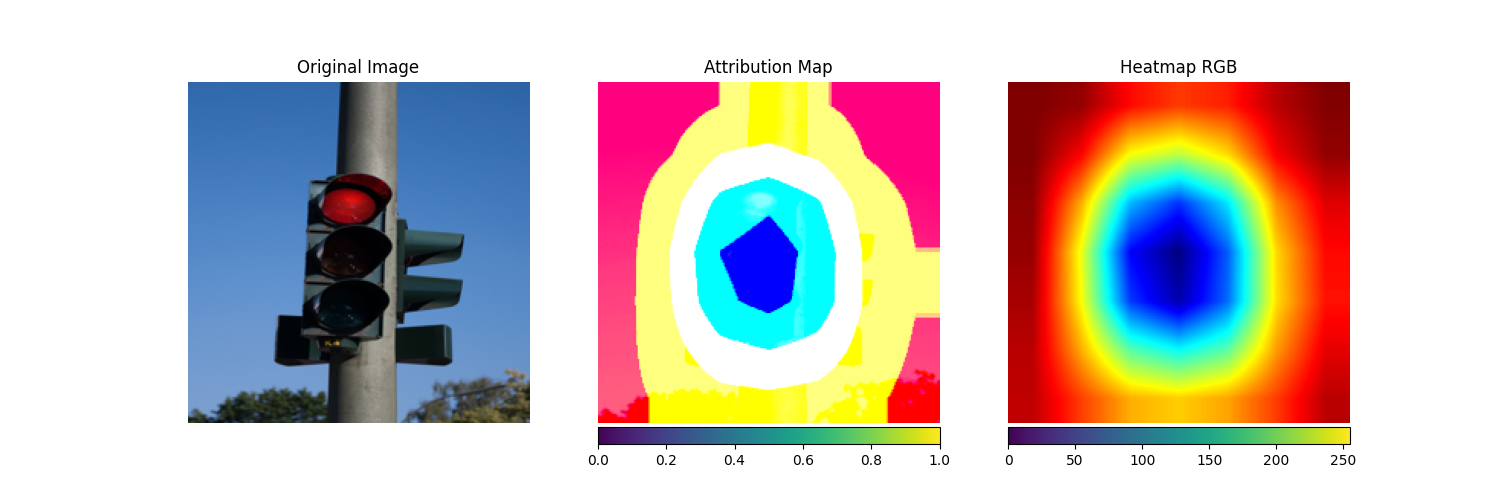

In [ ]:
# Plot the original image, the attribution map, and the heatmap RGB image in a single row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img.resize((input_size, input_size)))
axs[0].axis('off')
axs[0].set_title('Original Image')

im1 = axs[1].imshow(attribution)
axs[1].axis('off')
axs[1].set_title('Attribution Map')
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.046, pad=0.01)

im2 = axs[2].imshow(heatmap_rgb)
axs[2].axis('off')
axs[2].set_title('Heatmap RGB')
fig.colorbar(im2, ax=axs[2], orientation='horizontal', fraction=0.046, pad=0.01)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()
